# Simulating fibre-reinforced materials

This notebook will showcase:

* How to simulate a fibre-reinforced neo-Hookean material
* How to model slack in the fibre network
* Different models for fibre engagement (recruitment)
* Using the `homogeneous` option to decrease model build time

The `ucompress` package contains mechanical models for neo-Hookean materials that are reinforced with a transversely isotropic fibre network.  The fibres are aligned in the direction of the radial and circumferential direction, that is, all fibres are perpendicular to the axial direction.  Thus, the fibres provide reinforcement in the radial and circumferential directions.

Two types of fibre models have been implemented.  The `FibreReinforced` model is based on the assumption that all fibres in the network are engaged (active); that is, the fibres do not contain any slack so they contribute to tensile stress as soon as the material experiences a tensile strain.  The `FibreRecruitment` model accounts for fibre networks in which not all of the fibres are initially active.  That is, this model assumes there are some slack in the fibres, so a finite extension is required in order for them to contribute to the stress.  The impact of this slack is to cause the material to have an effective stiffness that increases with deformation, resulting in J-shaped stress-strain curves.  


In [1]:
import ucompress as uc
import matplotlib.pyplot as plt
import numpy as np

## Example 1 - Force-controlled loading of a fibre-reinforced material

In this first example, we simulate a force-controlled compression of a fibre-reinforced material using the `FibreReinforced` model.  An example parameter set for this is provided.  We will use the Holmes-Mow permeability, so we add two parameters into the parameter set:

In [2]:
pars = uc.parameters.example_parameters.FibreReinforced(nondim = False)
pars.physical["M"] = 2
pars.physical["a"] = 1

By printing the parameter values, we see that the Young's modulus of the fibres, $E_f$, and the nominal volume fraction of fibres, $\Phi_f$, are set.  The nominal volume fraction of fibres gives the volume fraction of fibres in the initial, undeformed state.

In [3]:
print(pars)

Dimensional parameter values
---------------------------------------
R = 5.00e-03
E_m = 5.00e+04
nu_m = 0.00e+00
E_f = 5.00e+07
Phi_f = 2.50e-01
k_0 = 2.00e-13
beta_r = 1.00e+00
beta_z = 1.00e+00
phi_0 = 8.00e-01
F = -1.00e+00
lam_z = 5.00e-01
t_start = 1.00e-02
t_end = 1.00e+04
M = 2.00e+00
a = 1.00e+00

Computational parameter values
-----------------------------------------
N = 40
Nt = 100
t_spacing = log



Now we define the mechanics, permeability, and the model objects.  Then we set up the force-controlled experiment, solve it, and plot the results.

--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 3.0


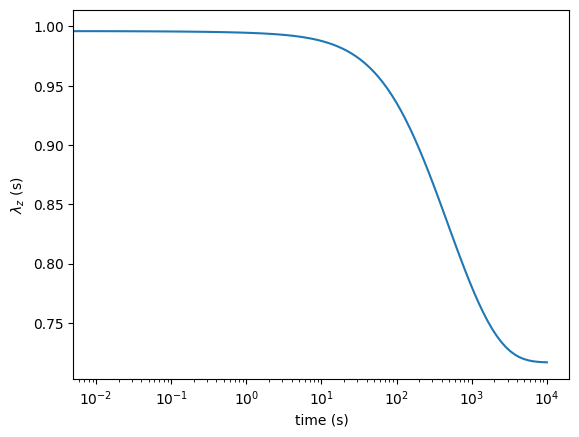

In [4]:
# Define the rest of the model
mech = uc.mechanics.FibreReinforced()
perm = uc.permeability.HolmesMow()

model = uc.base_models.Poroelastic(mech, perm, pars)

# Set up the force-controlled experiment and solve
problem = uc.experiments.ForceControlled(model, pars)
sol = problem.transient_response()

# Plot the axial stretch
plt.semilogx(sol.t, sol.lam_z)
plt.xlabel('time (s)')
plt.ylabel(r'$\lambda_z$ (s)')
plt.show()

Another interesting quantity to plot is the fluid load fraction.  This describes how much of the applied load is supported by the interstitial fluid.  The figure shows that nearly all of the applied load is initially supported by the fluid.  However, all of the load is eventually transferred to the solid as the interstitial fluid equilibrates with the surrounding fluid.

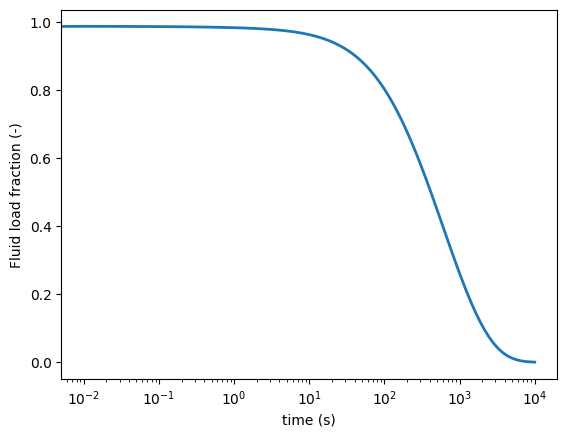

In [5]:
plt.semilogx(sol.t, sol.fluid_load_fraction, lw = 2)
plt.xlabel('time (s)')
plt.ylabel('Fluid load fraction (-)')
plt.show()

## Example 2 - Plotting the stress-strain curve with slack in the fibre network

A key feature of slack in the fibre network is that it leads to an effective material stiffness that increases in time to the gradual recruitment (engagement) of fibres.  This leads to J-shaped stress-strain curves. To see this, we plot the radial stress $S_r$ as a function of radial stretch $\lambda_r$:

In [6]:
# Load example parameters for FibreRecruitment model
pars = uc.parameters.example_parameters.FibreRecruitment()

# Load the mechanical model
mech = uc.mechanics.FibreRecruitment(homogeneous=False)
perm = None

# Build the model
model = uc.base_models.Poroelastic(mech, perm, pars)

We compute the instantaneous stres-strain curve.  So, following Tutorial 05, we define the stretches (respecting incompressibility), then evaluate the stresses, and finally plot.

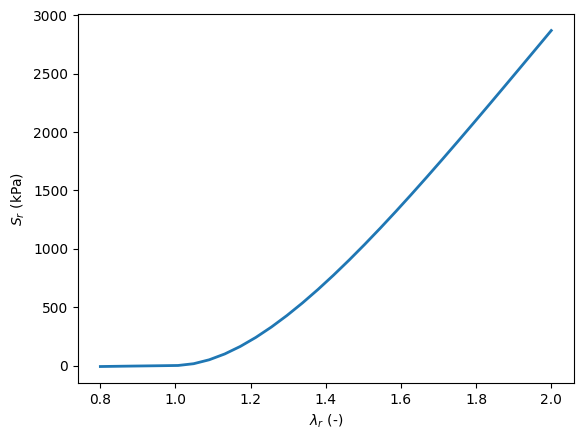

In [7]:
# Define the stretches
lam_r = np.linspace(0.8, 2, 30)
lam_z = 1 / lam_r**2

# Evaluate the stresses
S_r, _, _ = model.mechanics.eval_stress(lam_r, lam_r, lam_z)

# Plot
plt.plot(lam_r, S_r / 1e3, lw = 2)
plt.xlabel(r'$\lambda_r$ (-)')
plt.ylabel(r'$S_r$ (kPa)')
plt.show()

## Example 3 - Decreasing model build time and solves for homogeneous deformations

Due to the complexity of the fibre-recruitment models, building the symbolic expressions and converting these into NumPy functions by assigning parameter values can be relatively slow:

In [8]:
# time the construction of the symbolic expressions
%timeit uc.mechanics.FibreRecruitment()

122 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This means the parameter sweeps can be prohibitively slow.  If the deformation is homogeneous and the radial and circumferential (hoop) stretches given by $\lambda_r$ and $\lambda_\theta$ are equal ($\lambda_r = \lambda_\theta$), then the symbolic expressions for fibre-reinforced materials can be simplified and the model building can be sped up.  The `homogeneous` flag can be set to `True` when creating the mechanics object:

In [9]:
# time the construction of the symbolic expressions using the homogeneous option
%timeit uc.mechanics.FibreRecruitment(homogeneous = True)

2.4 ms ± 18 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we see, the model building is 50 times faster!  There will also be significant speed ups when solving the model, e.g. for the instantaneous and equilibrium responses.

## Example 4 - Exploring different fibre recruitment models

The fibre recruitment models are based on the assumption that the critical stretch $\lambda_c$ needed to engage a fibre is drawn from a probability density function $f(\lambda_c)$.  Three fibre recruitment distribution functions have been implemented in `ucompress.py`:

The **linear** distribution assumes the probability of engaging a fibre is a linear decreasing function given by
\begin{align}
f(\lambda_c) = \begin{cases}
0, &\quad \lambda_c < 1, \\
\dfrac{2(\lambda_m -\lambda_c)}{(\lambda_m-1)^2}, &\quad 1 < \lambda_c < \lambda_m, \\
0, &\quad \lambda_c > \lambda_m,
\end{cases}
\end{align}
where $\lambda_m$ is the maximum recruitment stretch, which describes the maximum stretch required to engage all fibres in the network.  The mode of the linear distribution is at $\lambda_c = 1$, meaning most of the fibres in the undeformed state are engaged.

The **quartic** distribution is given by
\begin{align}
    f(\lambda_c)=\begin{cases}
        0, & \lambda_c\le1,\\
        \dfrac{60\lambda_c^2(\lambda_c-1)(\lambda_c-\lambda_m)}{3-5\lambda_m+5\lambda_m^4-3\lambda_m^5}, & 1\le\lambda_c\le\lambda_m,\\
        0, & \lambda_c\ge\lambda_m.
    \end{cases}
\end{align}
In this case, the mode lies between $\lambda_c = 1$ and $\lambda_c = \lambda_m$.  This describes a situation where a finite deformation is required to engage most of the fibres.

The **triangle** distribution is, in effect, a linear approximation of the quartic distribution.  The definition of the triangular distribution is
\begin{align}
f(\lambda_c) = \begin{cases}
0, &\quad \lambda_c < a, \\
\dfrac{2(\lambda_c - a)}{(b-a)(c-a)}, &\quad a < \lambda_c < c, \\
\dfrac{2(b - \lambda_c)}{(b-a)(b-c)}, &\quad c < \lambda_c < b, \\
0, &\quad \lambda_c > b.
\end{cases}
\end{align}
In this case, $b$ represents the maximum recruitment stretch.  The mode of the distribution is located at $c$.  The critical stretch needed to engage any fibre is $a$.

The probability density function can be selected when creating the `FibreRecruitment` object using the `distribution` argument

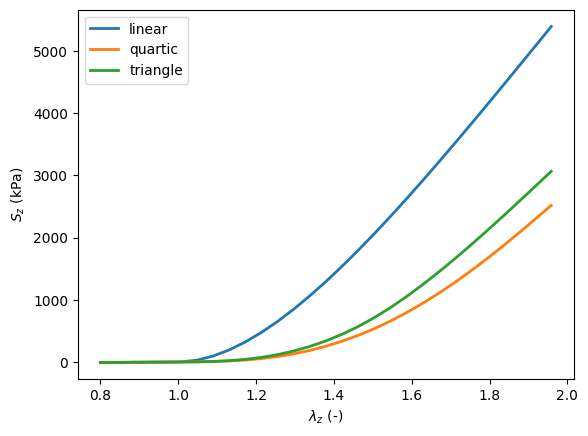

In [10]:
# Recruitment distribution models
distributions = ['linear', 'quartic', 'triangle']

# Add parameters for triangle distribution
pars.physical["lam_a"] = 1;
pars.physical["lam_c"] = 1.5
pars.physical["lam_b"] = 2


# Loop over recruitment models and plot stress-strain curve
for dist in distributions:

    # Define the model
    mech = uc.mechanics.FibreRecruitment(distribution = dist, homogeneous = True)
    model = uc.base_models.Poroelastic(mech, None, pars)
    
    # Evaluate the stresses
    S_r, _, _ = model.mechanics.eval_stress(lam_r, lam_r, lam_z)
    
    plt.plot(lam_r, S_r / 1e3, lw = 2, label = dist)

plt.xlabel(r'$\lambda_z$ (-)')
plt.ylabel(r'$S_z$ (kPa)')
plt.legend()
plt.show()